In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.signal import butter, freqz, lfilter, spectrogram

In [3]:
df = pd.read_table(
    "C:/Users/macka/Google Drive/Level-4-Project/data/raw/Dataset_97.dat",
    sep="\n",
    header=None)

In [4]:
def convert_to_complex(complex_string):
    return complex(complex_string[0].replace('i', 'j'))

In [5]:
center_frequency = float(df.iloc[0])
sweep_time = float(df.iloc[1])/1000  # convert to seconds
number_of_time_samples = float(df.iloc[2])
bandwidth = float(df.iloc[3])
sampling_frequency = number_of_time_samples/sweep_time
record_length = 60
number_of_chirps = record_length/sweep_time

In [6]:
data = df.iloc[4:]
data = data.apply(convert_to_complex, axis=1)
data = data.values

In [7]:
data_time = np.reshape(data, (int(number_of_time_samples), int(number_of_chirps)))

In [8]:
win = np.ones((int(number_of_time_samples), data_time.shape[1]))

In [9]:
tmp = np.fft.fft(data_time * win)

In [10]:
fftshifted = np.fft.fftshift(tmp, 0)

In [11]:
data_range = fftshifted[int(number_of_time_samples/2):int(number_of_time_samples), :]

In [12]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

In [13]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1

In [14]:
data_range_MTI = np.zeros((data_range.shape[0], ns))

In [15]:
(b, a) = butter(4, 0.01, btype="high")

In [16]:
(f1, h) = freqz(b, a, ns)

In [17]:
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns])

C:\Users\macka\Anaconda3\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [18]:
freq = np.arange(0, ns-1)
freq = freq * sampling_frequency/(2*ns)

[0.00000000e+00 1.06666667e+00 2.13333333e+00 ... 6.39957333e+04
 6.39968000e+04 6.39978667e+04]
60000


In [19]:
range_axis = (freq * 3e8*sweep_time)/(2*bandwidth)

In [20]:
data_range_MTI = data_range_MTI[1:, :]
data_range = data_range[1:, :]

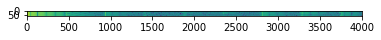

In [21]:
plt.imshow(20 * np.log10(abs(data_range_MTI[:, :4000])))

In [156]:
bin_indl = 5
bin_indu = 25
MD = {}
MD["PRF"] = 1/sweep_time
MD["TimeWindowLength"] = 200
MD["OverlapFactor"] = 0.95
MD["OverlapLength"] = np.round(MD["TimeWindowLength"] * MD["OverlapFactor"])
MD["Pad_Factor"] = 4
MD["FFTPoints"] = MD["Pad_Factor"]*MD["TimeWindowLength"]
MD["DopplerBin"] = MD["PRF"]/MD["FFTPoints"]
MD["DopplerAxis"] = np.arange(-MD["PRF"]/2, MD["PRF"]/2-MD["DopplerBin"]+1, MD["DopplerBin"])               
MD["WholeDuration"] = data_range_MTI.shape[1]/MD["PRF"]

MD["NumSegments"] = np.floor(
    (data_range_MTI.shape[1]-MD["TimeWindowLength"])/
    (np.floor(MD["TimeWindowLength"]*(1-MD["OverlapFactor"])))
)

In [158]:
data_spec_MTI2=0
for rbin in range(bin_indl-1, bin_indu):
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(MD["TimeWindowLength"]),
                            noverlap=MD["OverlapLength"],
                            NFFT=MD["TimeWindowLength"], 
                            mode='complex',
                            pad_to=MD["FFTPoints"] )
    print(s.shape, f.shape, t.shape)
    print(rbin)
    data_MTI_temp = np.fft.fftshift(s, 0)
    data_spec_MTI2=data_spec_MTI2+abs(data_MTI_temp);                                


(401, 5981) (401,) (5981,)
4
(401, 5981) (401,) (5981,)
5
(401, 5981) (401,) (5981,)
6
(401, 5981) (401,) (5981,)
7
(401, 5981) (401,) (5981,)
8
(401, 5981) (401,) (5981,)
9
(401, 5981) (401,) (5981,)
10
(401, 5981) (401,) (5981,)
11
(401, 5981) (401,) (5981,)
12
(401, 5981) (401,) (5981,)
13
(401, 5981) (401,) (5981,)
14
(401, 5981) (401,) (5981,)
15
(401, 5981) (401,) (5981,)
16
(401, 5981) (401,) (5981,)
17
(401, 5981) (401,) (5981,)
18
(401, 5981) (401,) (5981,)
19
(401, 5981) (401,) (5981,)
20
(401, 5981) (401,) (5981,)
21
(401, 5981) (401,) (5981,)
22
(401, 5981) (401,) (5981,)
23
(401, 5981) (401,) (5981,)
24


In [159]:
print(data_spec_MTI2.shape)

(401, 5981)


In [160]:
MD["TimeAxis"] = np.linspace(0,MD["WholeDuration"], data_spec_MTI2.shape[1])

In [161]:
data_spec_MTI2 = np.flipud(data_spec_MTI2/np.max(data_spec_MTI2[:]))

In [162]:
print(data_spec_MTI2.shape)
print(MD["TimeAxis"].shape, MD["DopplerAxis"].shape, (20*np.log10(abs(data_spec_MTI2))).shape)

(401, 5981)
(5981,) (800,) (401, 5981)


TypeError: Dimensions of C (401, 5981) are incompatible with X (5981) and/or Y (800); see help(pcolormesh)

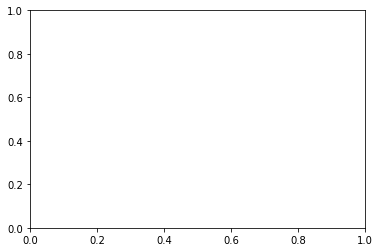

In [163]:
plt.pcolormesh(MD["TimeAxis"], MD["DopplerAxis"], 20*np.log10(abs(data_spec_MTI2)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()